## LSTM Forecasting of vibration and sensor data of a HV transformer

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from google.colab import drive

from sklearn.preprocessing import MinMaxScaler

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

Hyperparameters

In [8]:
#Lookback period
lookback = 30

#How far in the future the prediciton is made
forecast_horizon = 14

#Split between training and test set
split_perc = 0.80

#Size of training batches
batch_size = 8

#Number of neurons in the hidden layers
hidden_layer_size = 200

#Number of stacked LSTM layers
num_stacked_layers = 1

#Step taken in oposite direction of the gradient
learning_rate = 0.001

#Numbers of full forward passes of the dataset
num_epochs = 8

##Importing and reshaping data

In [9]:
#drive.mount('/content/gdrive')

In [10]:
df_sensor = pd.read_csv('Int LAG Health Metrics.csv')

dataset = df_sensor.to_numpy()
dataset = dataset[:,3:6]

Normalization of the frequency complexity data

In [11]:
#scaler = MinMaxScaler()
#dataset = scaler.fit_transform(dataset)

In [12]:
scaler_top = MinMaxScaler()
scaler_middle = MinMaxScaler()
scaler_bottom = MinMaxScaler()

dataset[:, 0] = scaler_top.fit_transform(dataset[:, 0].reshape(-1, 1)).flatten()
dataset[:, 1] = scaler_middle.fit_transform(dataset[:, 1].reshape(-1, 1)).flatten()
dataset[:, 2] = scaler_bottom.fit_transform(dataset[:, 2].reshape(-1, 1)).flatten()

In [13]:
dataset

array([[0.55866863, 0.33862265, 0.14675009],
       [0.92489387, 0.74064021, 0.75820571],
       [0.78093736, 0.37588538, 0.30868082],
       [0.9956733 , 0.578842  , 0.28901763],
       [0.74778472, 0.78179863, 0.26935444],
       [0.49989614, 0.33530026, 0.24969125],
       [0.23297281, 0.23737371, 0.66812819],
       [0.28791936, 0.43078045, 0.72638864],
       [0.31962747, 0.73075092, 0.        ],
       [0.53572278, 0.25787009, 0.83292127],
       [0.62921745, 0.0242132 , 0.73141148],
       [0.26972179, 0.47953439, 0.0921385 ],
       [0.38161038, 0.21047553, 0.0453258 ],
       [0.74856631, 0.51699195, 0.11539004],
       [0.24699125, 0.05621227, 0.08901993],
       [0.68407872, 0.50107426, 0.23711652],
       [0.34299068, 0.29952487, 0.19062266],
       [0.44003335, 0.12599579, 0.24307299],
       [0.47752598, 0.18036708, 0.74203137],
       [0.16298534, 0.23452131, 0.71868226],
       [0.31768328, 0.03204636, 0.04823495],
       [0.42622656, 0.21127197, 0.0750933 ],
       [0.

##Creating sequential data for forecasting, with train/test split

Function for creating forecasting data set (for 6 features and lables)

In [14]:
#def create_inout_sequences(input_data, lookback, forecast_horizon):
#    inout_seq = []
#    L = len(input_data)
#    for i in range(L - lookback - forecast_horizon + 1):  # Adjust the range to account for forecasting
 #       train_seq = input_data[i:i + lookback]
#        train_label = input_data[i + lookback:i + lookback + forecast_horizon]  # Next 20 steps
#        inout_seq.append((train_seq, train_label))
#    return inout_seq

In [15]:
def create_inout_sequences(input_data, lookback, forecast_horizon):
    inout_seq = []
    L = len(input_data)
    for i in range(L - lookback - forecast_horizon + 1):
        train_seq = input_data[i:i + lookback]
        train_label = input_data[i + lookback + forecast_horizon - 1]  # Only the 20th data point
        inout_seq.append((train_seq, train_label))
    return inout_seq

Defining lookback, and creating dataset for lengths

In [16]:
data = create_inout_sequences(dataset, lookback, forecast_horizon)

Defining train/test split

In [17]:
train_size = int(len(data) * split_perc)
test_size = len(data) - train_size
train, test = dataset[:train_size],dataset[train_size:]

In [18]:
train.shape,test.shape

((114, 3), (72, 3))

Creating sequential data

In [19]:
train_data = create_inout_sequences(train, lookback, forecast_horizon)
test_data = create_inout_sequences(test, lookback, forecast_horizon)

In [20]:
X_train, y_train = [], []
X_test, y_test = [], []

#Training data
for seq, label in train_data:
    X_train.append(seq)
    y_train.append(label)

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
y_train = y_train.squeeze(1)

#Test data
for seq, label in test_data:
    X_test.append(seq)
    y_test.append(label)

X_test = np.array(X_test, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()
y_test = y_test.squeeze(1)

Resulting data tensors

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([71, 30, 3]),
 torch.Size([29, 30, 3]),
 torch.Size([71, 3]),
 torch.Size([29, 3]))

Making tensors into torch datasets

In [22]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

In [23]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

Data loading for batch training

In [24]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##Creating and training LSTM model

#Model class

In [25]:
class LSTM(nn.Module):
    def __init__(self, num_features, hidden_layer_size, output_size, forecast_horizon, num_stacked_layers):
        super().__init__()
        self.output_size = output_size
        self.num_stacked_layers = num_stacked_layers
        self.forecast_horizon = forecast_horizon
        self.lstm = nn.LSTM(input_size=num_features,
                            hidden_size=hidden_layer_size,
                            batch_first=True, num_layers=num_stacked_layers)
        #self.linear = nn.Linear(hidden_layer_size, output_size * forecast_horizon)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq)
        predictions = self.linear(lstm_out[:, -1, :])
        # Access 'forecast_horizon' and 'output_size' as instance variables
        #predictions = predictions.view(-1, self.forecast_horizon, self.output_size)
        return predictions

# 'device' must be defined previously, e.g., device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM(num_features=3, hidden_layer_size=hidden_layer_size, output_size=3, forecast_horizon=20,num_stacked_layers=num_stacked_layers)
model.to(device) # assumes 'device' is defined elsewhere, e.g., device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model

LSTM(
  (lstm): LSTM(3, 200, batch_first=True)
  (linear): Linear(in_features=200, out_features=3, bias=True)
)

#Training and validation loop

In [26]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [28]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

#Training and plotting

In [29]:
for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1

Val Loss: 0.050
***************************************************

Epoch: 2

Val Loss: 0.054
***************************************************

Epoch: 3

Val Loss: 0.052
***************************************************

Epoch: 4

Val Loss: 0.053
***************************************************

Epoch: 5

Val Loss: 0.052
***************************************************

Epoch: 6

Val Loss: 0.053
***************************************************

Epoch: 7

Val Loss: 0.052
***************************************************

Epoch: 8

Val Loss: 0.054
***************************************************



In [30]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

with torch.no_grad():
    predicted_test = model(X_test.to(device)).to('cpu').numpy()

In [31]:
# unscaling data
actual_train_s1 = scaler_top.inverse_transform(y_train[:, 0].reshape(-1, 1)).flatten()
actual_train_s2 = scaler_top.inverse_transform(y_train[:, 1].reshape(-1, 1)).flatten()
actual_train_s3 = scaler_top.inverse_transform(y_train[:, 2].reshape(-1, 1)).flatten()

actual_test_s1 = scaler_top.inverse_transform(y_test[:, 0].reshape(-1, 1)).flatten()
actual_test_s2 = scaler_top.inverse_transform(y_test[:, 1].reshape(-1, 1)).flatten()
actual_test_s3 = scaler_top.inverse_transform(y_test[:, 2].reshape(-1, 1)).flatten()

predicted_train_s1 = scaler_top.inverse_transform(predicted[:, 0].reshape(-1, 1)).flatten()
predicted_train_s2 = scaler_top.inverse_transform(predicted[:, 1].reshape(-1, 1)).flatten()
predicted_train_s3 = scaler_top.inverse_transform(predicted[:, 2].reshape(-1, 1)).flatten()

predicted_test_s1 = scaler_top.inverse_transform(predicted_test[:, 0].reshape(-1, 1)).flatten()
predicted_test_s2 = scaler_top.inverse_transform(predicted_test[:, 1].reshape(-1, 1)).flatten()
predicted_test_s3 = scaler_top.inverse_transform(predicted_test[:, 2].reshape(-1, 1)).flatten()

actual_trains = np.column_stack((actual_train_s1,actual_train_s2))
actual_trains = np.column_stack((actual_trains,actual_train_s3))

actual_tests = np.column_stack((actual_test_s1,actual_test_s2))
actual_tests = np.column_stack((actual_tests,actual_test_s3))

predicted_trains = np.column_stack((predicted_train_s1,predicted_train_s2))
predicted_trains = np.column_stack((predicted_trains,predicted_train_s3))

predicted_tests = np.column_stack((predicted_test_s1,predicted_test_s1))
predicted_tests = np.column_stack((predicted_tests,predicted_test_s3))

In [32]:
predicted_trains


array([[4.153053 , 2.66772  , 2.5864074],
       [4.1644235, 2.673819 , 2.6178944],
       [4.3163304, 2.8710923, 2.79425  ],
       [4.3788824, 2.9563453, 2.8346143],
       [4.475821 , 3.0426848, 2.9039526],
       [4.42207  , 3.0593233, 2.8739727],
       [4.2817044, 2.9987385, 2.7908275],
       [4.1013517, 2.8634543, 2.668513 ],
       [4.0339675, 2.7858684, 2.6273553],
       [3.800584 , 2.7810163, 2.5946412],
       [3.9863997, 2.8406878, 2.691218 ],
       [4.096537 , 2.9001822, 2.7515943],
       [4.2582808, 2.9202373, 2.7819915],
       [4.2335224, 2.9224234, 2.7630656],
       [4.2639747, 3.018244 , 2.8429184],
       [4.1567783, 3.0346453, 2.8050492],
       [4.0035944, 3.0520926, 2.7782412],
       [3.8522487, 3.005542 , 2.7093294],
       [4.2337847, 3.091357 , 2.881337 ],
       [4.288071 , 3.0889323, 2.867286 ],
       [4.4166555, 3.1183019, 2.9135356],
       [4.459962 , 3.079741 , 2.8860803],
       [4.281914 , 3.0727909, 2.839038 ],
       [4.005538 , 3.0148902, 2.73

In [33]:
plot_actuals = np.row_stack((actual_trains,actual_tests[:forecast_horizon,:]))
plot_preds = np.row_stack((actual_trains[:forecast_horizon,:],predicted_trains))

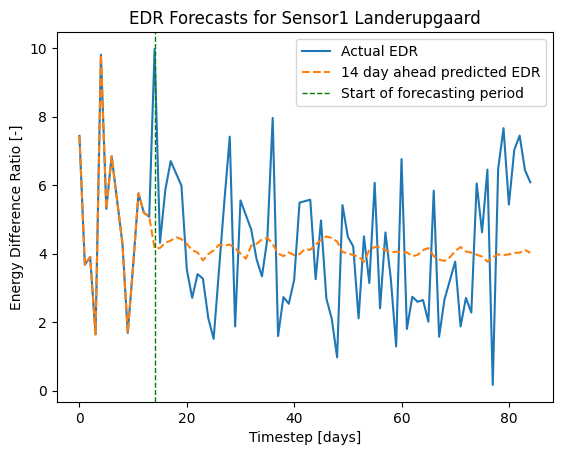

In [34]:
plt.plot(plot_actuals[:,0], label="Actual EDR")
plt.plot(plot_preds[:,0], label="14 day ahead predicted EDR", linestyle="--")
plt.xlabel('Timestep [days]')
plt.ylabel('Energy Difference Ratio [-]')
plt.title("EDR Forecasts for Sensor1 Landerupgaard")
plt.axvline(x=forecast_horizon, color='g', linestyle='--', linewidth=1, label="Start of forecasting period")
plt.legend()
plt.show()

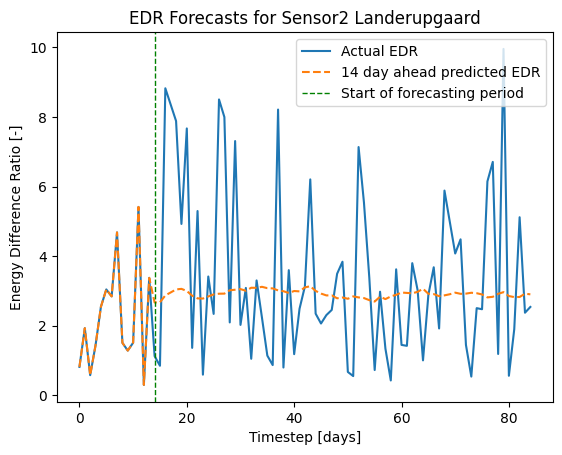

In [35]:
plt.plot(plot_actuals[:,1], label="Actual EDR")
plt.plot(plot_preds[:,1], label="14 day ahead predicted EDR", linestyle="--")
plt.xlabel('Timestep [days]')
plt.ylabel('Energy Difference Ratio [-]')
plt.axvline(x=forecast_horizon, color='g', linestyle='--', linewidth=1, label="Start of forecasting period")
plt.title("EDR Forecasts for Sensor2 Landerupgaard")
plt.legend()
plt.show()

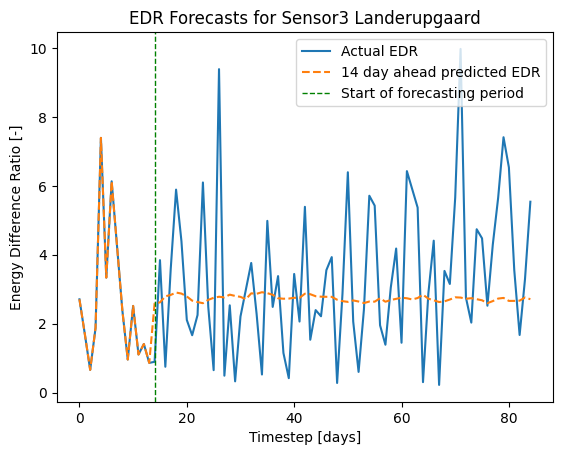

In [36]:
plt.plot(plot_actuals[:,2], label="Actual EDR")
plt.plot(plot_preds[:,2], label="14 day ahead predicted EDR", linestyle="--")
plt.xlabel('Timestep [days]')
plt.ylabel('Energy Difference Ratio [-]')
plt.axvline(x=forecast_horizon, color='g', linestyle='--', linewidth=1, label="Start of forecasting period")
plt.title("EDR Forecasts for Sensor3 Landerupgaard")
#plt.text(3, 25, 'x=3', color='r', rotation=90, verticalalignment='center')
plt.legend()
plt.show()